# Import Dependensi dan Variabel

In [119]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.experimental import enable_iterative_imputer  # noqa
from sklearn.impute import IterativeImputer
from sklearn.impute import KNNImputer
from statsmodels.formula.api import ols
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures

In [120]:
from variabel import variabel as var

# Import Data

In [121]:
df_gravimetri = pd.read_csv('hasil/ET Aktual Gravimetri.csv')
df_bc = pd.read_csv('hasil/Estimasi ET Blaney-Criddle.csv')
df_hs = pd.read_csv('hasil/Estimasi ET Hargreaves-Samani.csv')
df_pm = pd.read_csv('hasil/Estimasi ET Penman-Monteith.csv')

# Heatmap Data

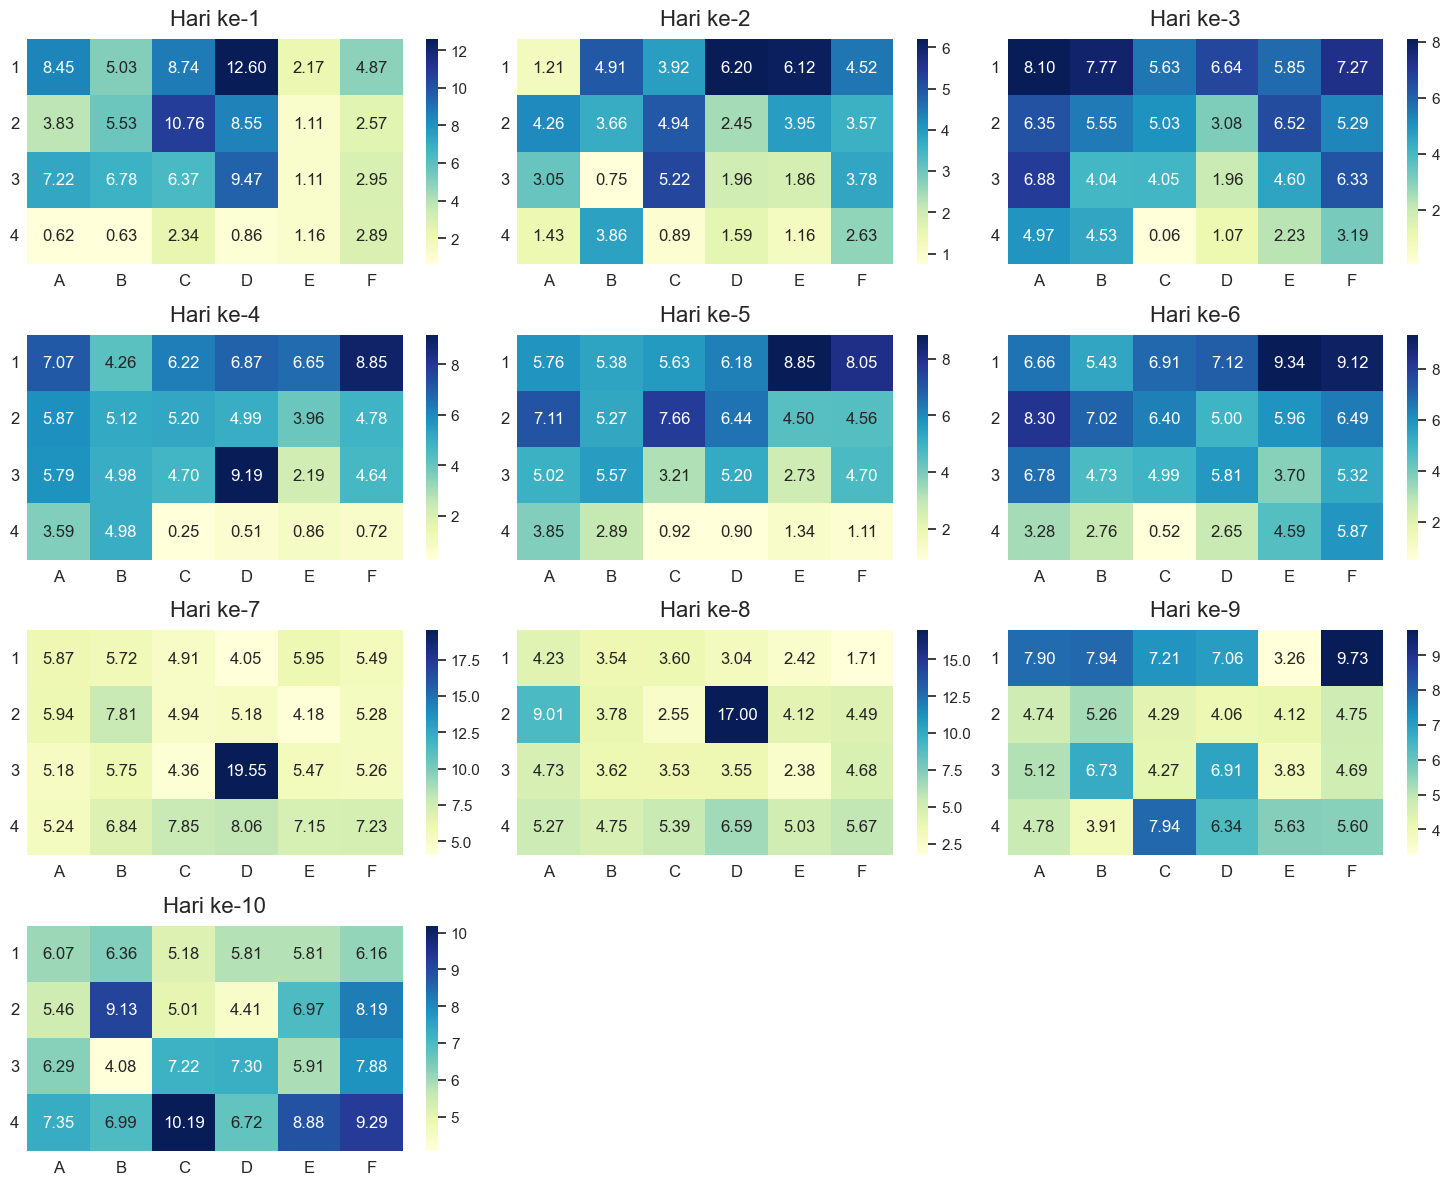

In [122]:
df_gravimetri.set_index('Num Day', inplace=True)

# Plot heatmaps
fig, axes = plt.subplots(4, 3, figsize=(15, 12))  # 4x3 grid
axes = axes.flatten()

for i, (day, data) in enumerate(df_gravimetri.iterrows()):
    # Reshape data untuk heatmap
    day_data = data.values.reshape(4, 6)  # Reshape ke (4x6)
    
    # Plot heatmap
    sns.heatmap(
        day_data, annot=True, fmt=".2f", cmap="YlGnBu",
        xticklabels=[], yticklabels=[], ax=axes[i]
    )
    axes[i].set_title(f"Hari ke-{i+1}", fontsize=16, pad=10)

    # Tambahkan label X (A-F) dan Y (1-4)
    for col in range(6):
        axes[i].text(col + 0.5, 4.3, f"{chr(65 + col)}", ha="center", va="center", fontsize=12)
    for row in range(4):
        axes[i].text(-0.2, row + 0.5, f"{row + 1}", ha="center", va="center", fontsize=12)

# Hilangkan subplot kosong jika jumlah hari kurang dari 12
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

In [123]:
df_gravimetri.index = range(1, len(df_gravimetri) + 1)
df_gravimetri.index.name = "Num Day"

In [124]:
df_gravimetri.head(2)

,A1,A2,A3,A4,B1,B2,B3,B4,C1,C2,...,D3,D4,E1,E2,E3,E4,F1,F2,F3,F4
Num Day,,,,,,,,,,,,,,,,,,,,,
1,8.4480,5.0304,8.7360,12.5952,2.173333,4.866667,3.826667,5.533333,10.755918,8.551837,...,6.3750,9.4650,1.108148,2.951111,0.622222,0.628148,2.3376,0.8592,1.1616,2.8896
2,1.2084,4.9140,3.9156,6.2004,6.124667,4.524667,4.258000,3.658000,4.935551,2.447388,...,5.2155,1.9605,1.855037,3.780963,1.428370,3.863926,0.8940,1.5948,1.1580,2.6268


# Cek Outlier

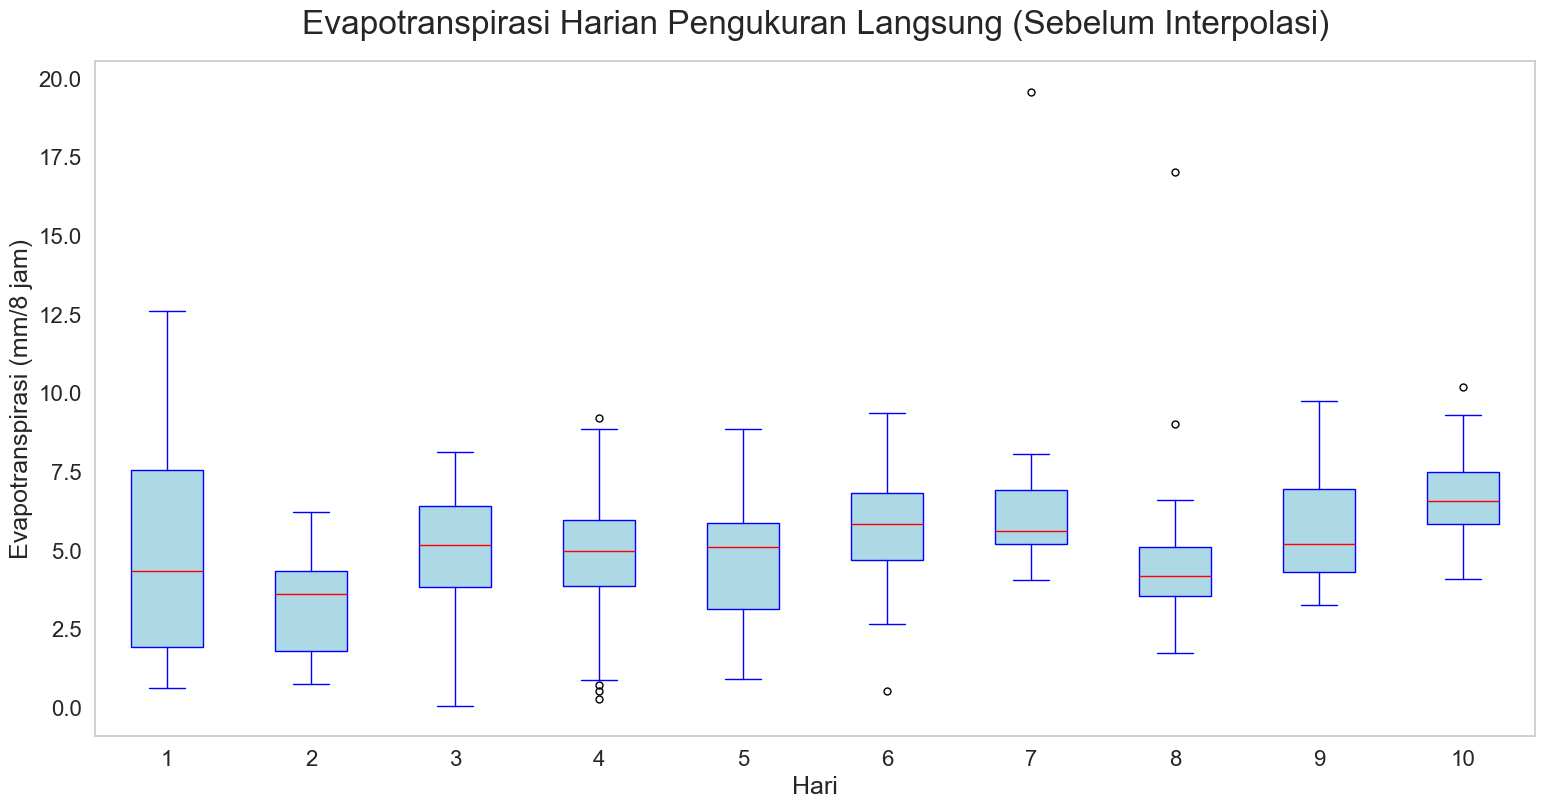

In [125]:
# Reset index to make 'Num Day' a column again
df_gravimetri_reset = df_gravimetri.reset_index()

# Convert df_gravimetri to long format
data_aktual_long = df_gravimetri_reset.melt(id_vars=['Num Day'], var_name='Day', value_name='Evapotranspirasi')

# Membuat plot boxplot dengan ukuran besar
fig, ax = plt.subplots(figsize=(18, 9))  # Ukuran figure diperbesar
boxplot = data_aktual_long.boxplot(by='Num Day', column='Evapotranspirasi', grid=False, patch_artist=True,
           boxprops=dict(facecolor='lightblue', color='blue'),
           whiskerprops=dict(color='blue'),
           capprops=dict(color='blue'),
           medianprops=dict(color='red'),
           flierprops=dict(marker='o', color='red', markersize=5),
           ax=ax)

# Tambahkan judul dan label
ax.set_title('Evapotranspirasi Harian Pengukuran Langsung (Sebelum Interpolasi)', fontsize=24, pad=20)
ax.set_xlabel('Hari', fontsize=18)
ax.set_ylabel('Evapotranspirasi (mm/8 jam)', fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

# Ubah keterangan sumbu x menjadi angka 1 sampai 10
ax.set_xticklabels(range(1, 11))

plt.suptitle('')

# Tampilkan plot
plt.show()


# Penanganan Outlier

In [126]:
# Function to detect outliers using IQR
def detect_outliers(df, multiplier=3):
    Q1 = df.quantile(0.25)
    Q3 = df.quantile(0.75)
    IQR = Q3 - Q1
    is_outlier = (df < (Q1 - multiplier * IQR)) | (df > (Q3 + multiplier * IQR))
    return is_outlier

In [127]:
# Function to handle outliers and fill missing values using IterativeImputer
def handle_outliers_with_iterative(df, max_iterations=100):
    imputer = IterativeImputer(max_iter=10, tol=1e-1000, random_state=0)
    iteration = 0
    best_df = df.copy()
    min_outliers = float('inf')

    while iteration < max_iterations:
        print(f"Iteration {iteration + 1}")
        # Detect outliers
        outliers = detect_outliers(df)
        num_outliers = outliers.sum().sum()

        # If the current iteration has fewer outliers, update the best_df
        if num_outliers < min_outliers:
            min_outliers = num_outliers
            best_df = df.copy()

        # If no outliers are detected, break the loop
        if num_outliers == 0:
            break

        # Replace outliers with NaN
        df[outliers] = np.nan

        # Apply Iterative imputation
        df.iloc[:, :] = imputer.fit_transform(df)

        iteration += 1

    # print(f"Best iteration with {min_outliers} outliers")
    return best_df


In [128]:
# Method with KNN Imputer
def handle_outliers_with_knn(df, max_iterations=100, n_neighbors=10, tol=1e-4):
    imputer = KNNImputer(n_neighbors=n_neighbors)
    prev_outliers = None

    for iteration in range(max_iterations):
        print(f"Iteration {iteration + 1}")
        # Detect outliers
        outliers = detect_outliers(df)
        num_outliers = outliers.sum().sum()

        # Break if no more outliers or improvement is too small
        if prev_outliers is not None and abs(prev_outliers - num_outliers) < tol:
            break
        prev_outliers = num_outliers

        # Replace outliers with NaN
        df[outliers] = np.nan

        # Impute missing values using KNN Imputer
        df.iloc[:, :] = imputer.fit_transform(df)

    return df

In [129]:
df_gravimetri_interpolate = df_gravimetri

In [130]:
polynomial_pipeline = make_pipeline(PolynomialFeatures(degree=2), LinearRegression())
imputer = IterativeImputer(estimator=polynomial_pipeline, max_iter=20, random_state=0)

# Handle outliers and fill missing values
df_gravimetri_interpolate = handle_outliers_with_knn(df_gravimetri_interpolate)

data_hari = [3, 7, 6]
for idx in data_hari:
    df_gravimetri_interpolate.loc[idx] = np.nan
    df_gravimetri_interpolate.iloc[:, :] = imputer.fit_transform(df_gravimetri_interpolate)

Iteration 1
Iteration 2


d:\OneDrive\04. University of Jember\01. Physics Academics\TUGAS AKHIR\04. Program-Evapotranspiration-Analysis\.venv\Lib\site-packages\sklearn\impute\_iterative.py:825: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
d:\OneDrive\04. University of Jember\01. Physics Academics\TUGAS AKHIR\04. Program-Evapotranspiration-Analysis\.venv\Lib\site-packages\sklearn\impute\_iterative.py:825: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


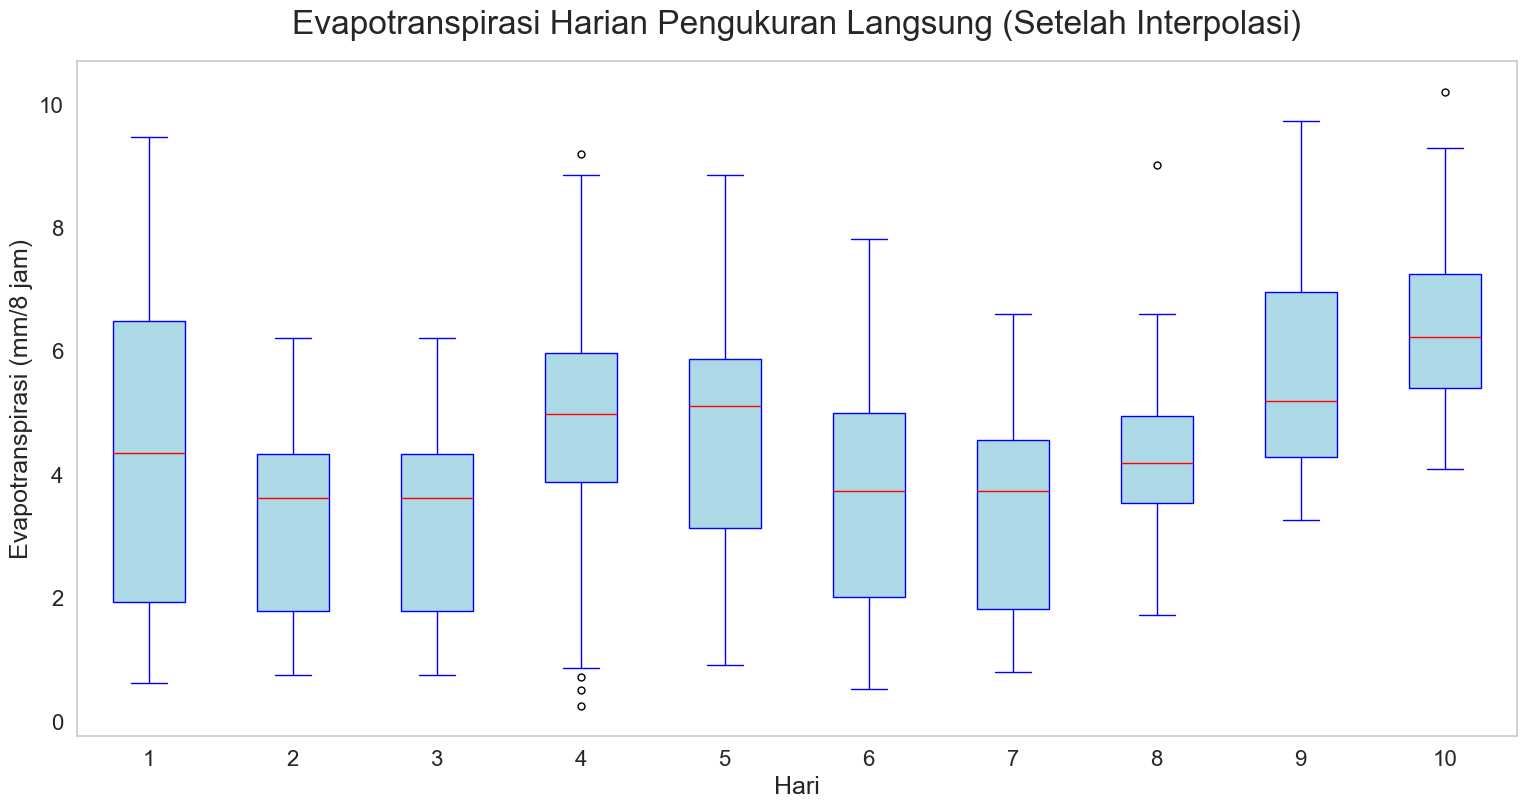

In [131]:
# Reset index to make 'Num Day' a column again
df_gravimetri_reset = df_gravimetri_interpolate.reset_index()

# Convert df_gravimetri to long format
data_aktual_long = df_gravimetri_reset.melt(id_vars=['Num Day'], var_name='Day', value_name='Evapotranspirasi')

# Membuat plot boxplot dengan ukuran besar
fig, ax = plt.subplots(figsize=(18, 9))
boxplot = data_aktual_long.boxplot(by='Num Day', column='Evapotranspirasi', grid=False, patch_artist=True,
           boxprops=dict(facecolor='lightblue', color='blue'),
           whiskerprops=dict(color='blue'),
           capprops=dict(color='blue'),
           medianprops=dict(color='red'),
           flierprops=dict(marker='o', color='red', markersize=5),
           ax=ax)

# Tambahkan judul dan label
ax.set_title('Evapotranspirasi Harian Pengukuran Langsung (Setelah Interpolasi)', fontsize=24, pad=20)
ax.set_xlabel('Hari', fontsize=18)
ax.set_ylabel('Evapotranspirasi (mm/8 jam)', fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

# Ubah keterangan sumbu x menjadi angka 1 sampai 10
ax.set_xticklabels(range(1, 11))

plt.suptitle('')

# Tampilkan plot
plt.show()


# Perbandingan Data Aktual dan Estimasi

In [132]:
df_bc = df_bc.reset_index(drop=True)
df_bc.index = df_bc.index + 1

df_hs = df_hs.reset_index(drop=True)
df_hs.index = df_hs.index + 1

df_pm = df_pm.reset_index(drop=True)
df_pm.index = df_pm.index + 1

In [133]:
# Define df_gravimetri_analisis
df_gravimetri_analisis = pd.DataFrame(index=df_gravimetri_interpolate.index)

# Menghitung rata-rata harian dari semua tanaman
df_gravimetri_analisis['Average'] = df_gravimetri_interpolate.iloc[:, 0:-1].mean(axis=1)

# Menghitung median untuk setiap hari
df_gravimetri_analisis['Median'] = df_gravimetri_interpolate.iloc[:, 0:-1].median(axis=1)

# Menghitung Standar Deviasi untuk setiap hari
df_gravimetri_analisis['STDEV'] = df_gravimetri_interpolate.iloc[:, 0:-1].std(axis=1)

# Menghitung IQR (Interquartile Range) untuk setiap hari
Q1 = df_gravimetri_interpolate.iloc[:, 1:-2].quantile(0.25, axis=1)
Q2 = df_gravimetri_interpolate.iloc[:, 1:-2].quantile(0.5, axis=1)
Q3 = df_gravimetri_interpolate.iloc[:, 1:-2].quantile(0.75, axis=1)
Q4 = df_gravimetri_interpolate.iloc[:, 1:-2].quantile(1, axis=1)

df_gravimetri_analisis['Q1'] = Q1
df_gravimetri_analisis['Q2'] = Q2
df_gravimetri_analisis['Q3'] = Q3
df_gravimetri_analisis['Q4'] = Q4
df_gravimetri_analisis['IQR'] = Q3 - Q1

df_gravimetri_analisis = df_gravimetri_analisis.round(2)
df_gravimetri_analisis.head()

,Average,Median,STDEV,Q1,Q2,Q3,Q4,IQR
Num Day,,,,,,,,
1,4.41,4.87,2.93,2.17,4.87,6.37,9.47,4.20
2,3.27,3.66,1.67,1.96,3.78,4.52,6.20,2.56
3,3.27,3.66,1.67,1.96,3.78,4.52,6.20,2.56
4,4.85,4.98,2.31,4.26,4.98,5.87,9.19,1.60
5,4.86,5.20,2.15,3.85,5.20,6.18,8.85,2.33


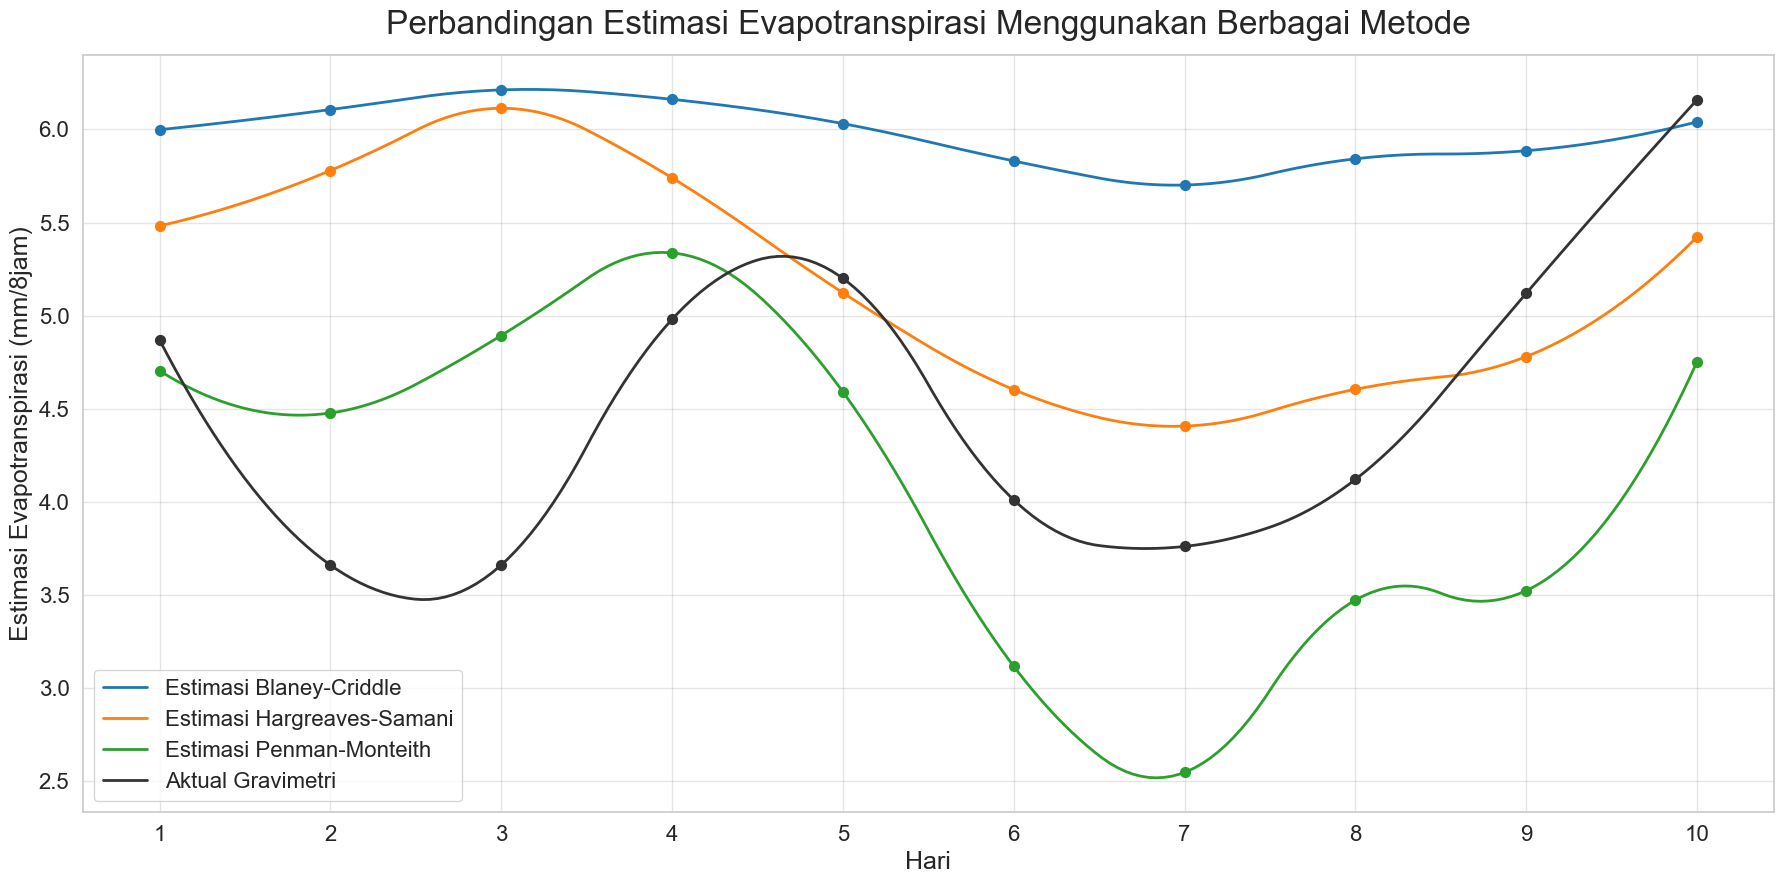

In [134]:
from scipy.interpolate import make_interp_spline

sns.set(style="whitegrid", palette="Set2")
plt.figure(figsize=(18, 9))

# Fungsi untuk membuat kurva melengkung dengan spline interpolasi
def smooth_curve(x, y, num_points=200):
    x_new = np.linspace(x.min(), x.max(), num_points)
    spline = make_interp_spline(x, y, k=2)  # k=3 untuk cubic spline
    y_smooth = spline(x_new)
    return x_new, y_smooth

# Plot data Blaney-Criddle
x_bc, y_bc = smooth_curve(df_bc.index, df_bc['ET Total'])
plt.plot(x_bc, y_bc, label='Estimasi Blaney-Criddle', color='#1f77b4', linewidth=2)
plt.scatter(df_bc.index, df_bc['ET Total'], color='#1f77b4', s=50, zorder=3)

# Plot data Hargreaves-Samani
x_hs, y_hs = smooth_curve(df_hs.index, df_hs['ET Total'])
plt.plot(x_hs, y_hs, label='Estimasi Hargreaves-Samani', color='#ff7f0e', linewidth=2)
plt.scatter(df_hs.index, df_hs['ET Total'], color='#ff7f0e', s=50, zorder=3)

# Plot data Penman-Monteith
x_pm, y_pm = smooth_curve(df_pm.index, df_pm['ET Total'])
plt.plot(x_pm, y_pm, label='Estimasi Penman-Monteith', color='#2ca02c', linewidth=2)
plt.scatter(df_pm.index, df_pm['ET Total'], color='#2ca02c', s=50, zorder=3)

# Plot data gravimetri
x_grav, y_grav = smooth_curve(df_gravimetri_analisis.index, df_gravimetri_analisis['Median'])
plt.plot(x_grav, y_grav, label='Aktual Gravimetri', color='#333333', linewidth=2)
plt.scatter(df_gravimetri_analisis.index, df_gravimetri_analisis['Median'], color='#333333', s=50, zorder=3)

# Judul dan label sumbu
plt.title('Perbandingan Estimasi Evapotranspirasi Menggunakan Berbagai Metode', fontsize=24, pad=15)
plt.xlabel('Hari', fontsize=18)
plt.ylabel('Estimasi Evapotranspirasi (mm/8jam)', fontsize=18)

# Menentukan ticks pada sumbu x dengan interval 1
x_min = min(df_bc.index.min(), df_hs.index.min(), df_pm.index.min(), df_gravimetri_analisis.index.min())
x_max = max(df_bc.index.max(), df_hs.index.max(), df_pm.index.max(), df_gravimetri_analisis.index.max())
plt.xticks(np.arange(x_min, x_max + 1, 1), fontsize=16)  # Rentang 1 untuk label x

plt.yticks(fontsize=16)

# Grid dan legenda
plt.grid(True, linestyle='-', color='gray', alpha=0.2)
plt.legend(fontsize=16, frameon=True, loc='lower left')

# Rentang sumbu y
# plt.ylim(2.5, 7)
plt.tight_layout()

# Tampilkan grafik
plt.show()

# Analisis Parameter

In [135]:
df_analisis_parameter = df_gravimetri_analisis[['Median']].copy()
df_analisis_parameter.rename(columns={'Median': 'Gravimetri'}, inplace=True)

df_analisis_parameter.loc[:, 'Blaney-Criddle'] = df_bc['ET Total']
df_analisis_parameter.loc[:, 'Hargreaves-Samani'] = df_hs['ET Total']
df_analisis_parameter.loc[:, 'Penman-Monteith'] = df_pm['ET Total']
df_analisis_parameter = df_analisis_parameter.round(2)
df_analisis_parameter

,Gravimetri,Blaney-Criddle,Hargreaves-Samani,Penman-Monteith
Num Day,,,,
1,4.87,6.00,5.48,4.70
2,3.66,6.11,5.78,4.48
3,3.66,6.21,6.11,4.89
4,4.98,6.16,5.74,5.34
5,5.20,6.03,5.12,4.59
6,4.01,5.83,4.60,3.12
7,3.76,5.70,4.41,2.55
8,4.12,5.84,4.60,3.47
9,5.12,5.89,4.78,3.52


In [136]:
# Fungsi menghitung akurasi
def calculate_akurasi(aktual, estimasi):
  error = np.abs(np.mean(estimasi) - np.mean(aktual)) / np.mean(aktual)
  akurasi = (1 - error) * 100
  return akurasi

In [137]:
# Fungsi untuk menghitung RMSE
def calculate_rmse(actual, estimates):
    return np.sqrt(mean_squared_error(actual, estimates))

In [138]:
# Fungsi untuk menghitung MAE
def calculate_mae(actual, estimates):
    return mean_absolute_error(actual, estimates)

In [139]:
# Fungsi untuk menghitung MBE
def calculate_mbe(actual, estimates):
    return np.mean(estimates - actual)

In [140]:
# Menghitung Akurasi, RMSE, MAE, dan MBE untuk setiap metode
results = {
    'Metode': ['Blaney-Criddle', 'Hargreaves-Samani', 'Penman-Monteith'],
    'Akurasi': [],
    'RMSE': [],
    'MAE': [],
    'MBE': []
}

# Define the actual values
actual = df_analisis_parameter['Gravimetri']

for column in results['Metode']:
    results['Akurasi'].append(calculate_akurasi(actual, df_analisis_parameter[column]))
    results['RMSE'].append(calculate_rmse(actual, df_analisis_parameter[column]))
    results['MAE'].append(calculate_mae(actual, df_analisis_parameter[column]))
    results['MBE'].append(calculate_mbe(actual, df_analisis_parameter[column]))

# Membuat dataframe dari hasil perhitungan
df_results = pd.DataFrame(results)
df_results = df_results.round(2)
df_results

,Metode,Akurasi,RMSE,MAE,MBE
0,Blaney-Criddle,68.66,1.63,1.45,1.43
1,Hargreaves-Samani,85.73,1.15,0.88,0.65
2,Penman-Monteith,90.93,1.00,0.89,-0.41


# Pisah Plot

In [141]:
df_gravimetri_interpolate.head()

,A1,A2,A3,A4,B1,B2,B3,B4,C1,C2,...,D3,D4,E1,E2,E3,E4,F1,F2,F3,F4
Num Day,,,,,,,,,,,,,,,,,,,,,
1,8.448000,5.030400,8.736000,5.885867,2.173333,4.866667,3.826667,5.533333,5.112054,8.551837,...,6.375000,9.465000,1.108148,2.951111,0.622222,0.628148,2.337600,0.859200,1.161600,2.889600
2,1.208400,4.914000,3.915600,6.200400,6.124667,4.524667,4.258000,3.658000,4.935551,2.447388,...,5.215500,1.960500,1.855037,3.780963,1.428370,3.863926,0.894000,1.594800,1.158000,2.626800
3,1.207284,4.913618,3.915212,6.200149,6.122498,4.523467,4.257079,3.657062,4.934426,2.446755,...,5.215714,1.960748,1.854544,3.780722,1.428142,3.864385,0.894464,1.595134,1.157726,2.626632
4,7.065600,4.262400,6.220800,6.873600,6.653333,8.853333,5.866667,5.120000,5.201633,4.986122,...,4.695000,9.187500,2.186667,4.640000,3.591111,4.977778,0.249600,0.508800,0.864000,0.720000
5,5.761200,5.377200,5.626800,6.183600,8.847333,8.047333,7.107333,5.267333,7.662980,6.443388,...,3.207750,5.195250,2.728074,4.695481,3.854000,2.891037,0.920400,0.901200,1.335600,1.107600


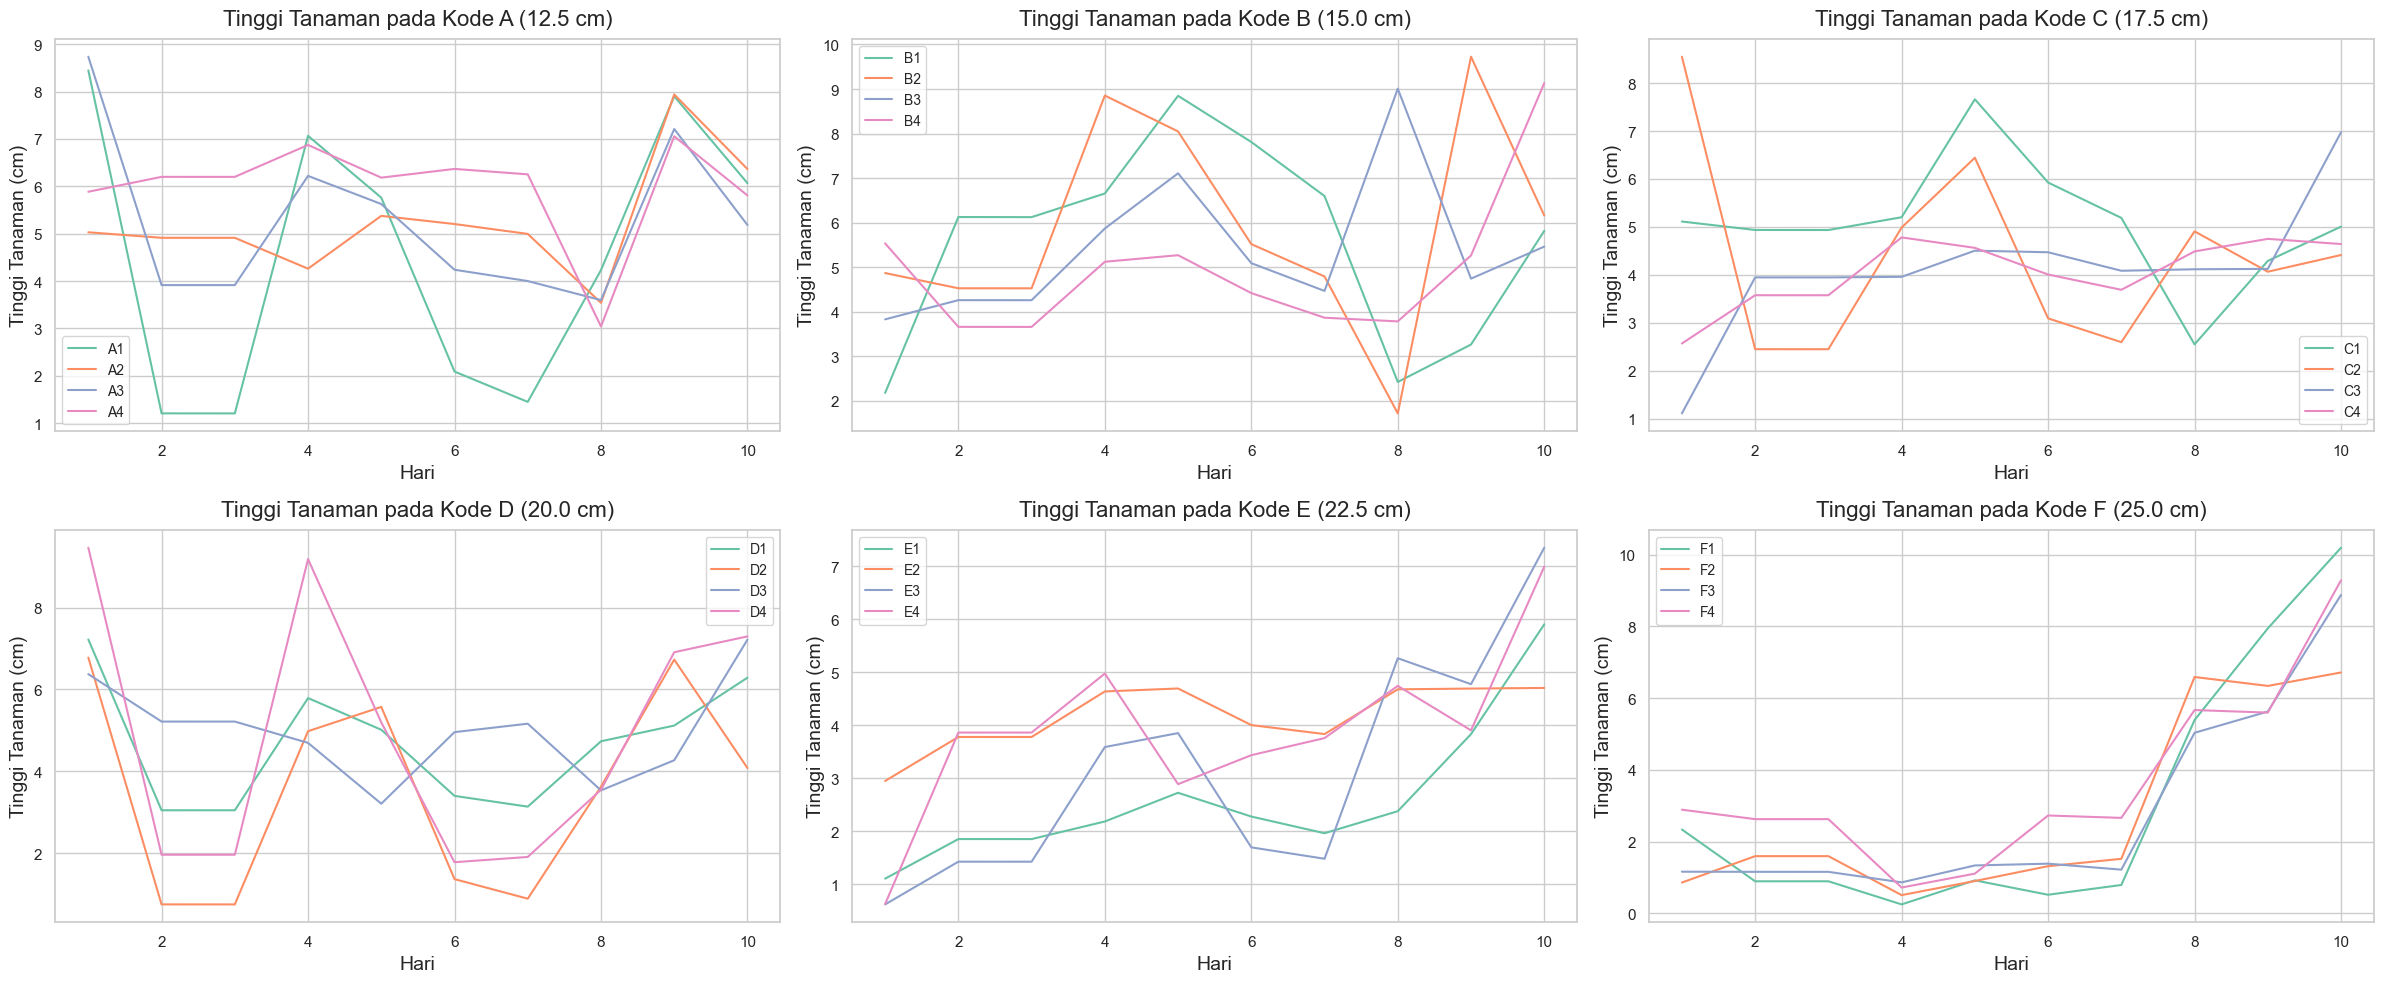

In [142]:
# Create a single figure with 6 subplots
fig, axes = plt.subplots(2, 3, figsize=(24, 10))
axes = axes.flatten()

for i, (pot, columns) in enumerate(var.pot_groups.items()):
    for col in columns:
        axes[i].plot(df_gravimetri_interpolate.index, df_gravimetri_interpolate[col], label=col)
    
    axes[i].set_title(f'Tinggi Tanaman pada Kode {pot} ({var.sisi_media_tanaman[var.pot_groups[pot][1]][0]} cm)', fontsize=16, pad=10)
    axes[i].set_xlabel('Hari', fontsize=14)
    axes[i].set_ylabel('Tinggi Tanaman (cm)', fontsize=14)
    axes[i].legend(fontsize=10)
    axes[i].grid(True)

plt.tight_layout()
plt.show()


# ANOVA

In [143]:
df_data_anova = pd.read_csv('hasil/Data Anova.csv')
df_data_anova.head()

,Kode,Day,Berat_Tanaman,Intensitas_Matahari,Tinggi_Tanaman,Luas_Permukaan_Wadah
0,A1,day 05,2.181938,78100.0,25,156.25
1,A2,day 05,3.039563,78100.0,40,156.25
2,A3,day 05,3.915938,78100.0,45,156.25
3,A4,day 05,3.264563,78100.0,60,156.25
4,B1,day 05,3.590562,78100.0,25,225.00


In [144]:
mean_values = df_gravimetri_interpolate.mean()
df_mean = mean_values.to_frame(name='Evapotranspirasi')
df_mean = df_mean.reset_index(names='Kode')

df_data_anova = df_data_anova.merge(df_mean, left_on="Kode", right_on="Kode", how="left")
df_data_anova.head()

,Kode,Day,Berat_Tanaman,Intensitas_Matahari,Tinggi_Tanaman,Luas_Permukaan_Wadah,Evapotranspirasi
0,A1,day 05,2.181938,78100.0,25,156.25,4.543222
1,A2,day 05,3.039563,78100.0,40,156.25,5.254387
2,A3,day 05,3.915938,78100.0,45,156.25,5.264776
3,A4,day 05,3.264563,78100.0,60,156.25,5.987107
4,B1,day 05,3.590562,78100.0,25,225.00,5.582273


In [145]:
print(df_data_anova['Tinggi_Tanaman'].unique())
print(df_data_anova['Luas_Permukaan_Wadah'].unique())
print(df_data_anova['Intensitas_Matahari'].unique())

[25 40 45 60]
[156.25 225.   306.25 400.   506.25 625.  ]
[78100.   68837.5  81381.25 63787.5  64418.75 41850.   72318.75 46100.
 49925.   65481.25]


In [146]:
model = ols('Evapotranspirasi ~ C(Tinggi_Tanaman) + C(Luas_Permukaan_Wadah)', data=df_data_anova).fit()
anova = sm.stats.anova_lm(model, typ=3)
print("Tabel Anova Hubungan Tinggi dan Luas Permukaan Wadah Terhadap Evapotranspirasi")
anova

Tabel Anova Hubungan Tinggi dan Luas Permukaan Wadah Terhadap Evapotranspirasi


,sum_sq,df,F,PR(>F)
Intercept,707.607270,1.0,3237.174041,7.079951e-138
C(Tinggi_Tanaman),3.783490,3.0,5.769592,8.043033e-04
C(Luas_Permukaan_Wadah),183.620227,5.0,168.005801,7.510420e-75
Residual,50.493819,231.0,NaN,NaN


In [147]:
model_interaksi = ols('Evapotranspirasi ~ C(Tinggi_Tanaman) * C(Luas_Permukaan_Wadah)', data=df_data_anova).fit()
anova_interaksi = sm.stats.anova_lm(model_interaksi, typ=3)
anova_interaksi


,sum_sq,df,F,PR(>F)
Intercept,2.064086e+02,1.0,7.342290e+30,0.0
C(Tinggi_Tanaman),1.042487e+01,3.0,1.236098e+29,0.0
C(Luas_Permukaan_Wadah),6.955208e+01,5.0,4.948160e+29,0.0
C(Tinggi_Tanaman):C(Luas_Permukaan_Wadah),5.049382e+01,15.0,1.197431e+29,0.0
Residual,6.072257e-27,216.0,NaN,NaN


In [148]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd

tukey = pairwise_tukeyhsd(
    endog=df_data_anova['Evapotranspirasi'],
    groups=df_data_anova['Tinggi_Tanaman'].astype(str) + ':' + df_data_anova['Luas_Permukaan_Wadah'].astype(str),
    alpha=0.05
)
# Menampilkan tabel hasil Tukey HSD
print(tukey.summary())

   Multiple Comparison of Means - Tukey HSD, FWER=0.05   
  group1    group2  meandiff p-adj  lower   upper  reject
---------------------------------------------------------
25:156.25  25:225.0   1.0391   0.0  1.0391  1.0391   True
25:156.25 25:306.25   0.5372   0.0  0.5372  0.5372   True
25:156.25  25:400.0   0.1367   0.0  0.1367  0.1367   True
25:156.25 25:506.25  -1.9334   0.0 -1.9334 -1.9334   True
25:156.25  25:625.0    -1.53   0.0   -1.53   -1.53   True
25:156.25 40:156.25   0.7112   0.0  0.7112  0.7112   True
25:156.25  40:225.0   1.3289   0.0  1.3289  1.3289   True
25:156.25 40:306.25  -0.1488   0.0 -0.1488 -0.1488   True
25:156.25  40:400.0  -0.9919   0.0 -0.9919 -0.9919   True
25:156.25 40:506.25  -0.3663   0.0 -0.3663 -0.3663   True
25:156.25  40:625.0  -1.7492   0.0 -1.7492 -1.7492   True
25:156.25 45:156.25   0.7216   0.0  0.7216  0.7216   True
25:156.25  45:225.0   0.8646   0.0  0.8646  0.8646   True
25:156.25 45:306.25  -0.4204   0.0 -0.4204 -0.4204   True
25:156.25  45:

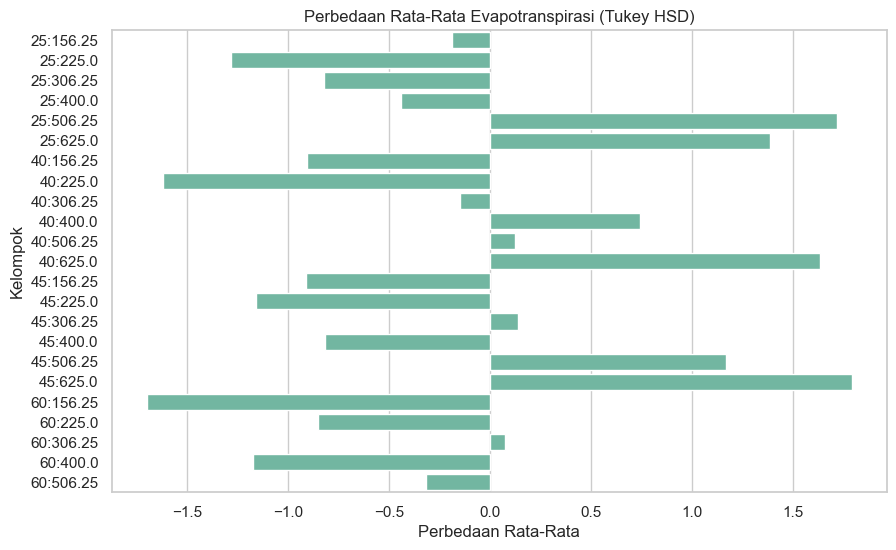

In [149]:
# Contoh visualisasi hasil Tukey
tukey_summary = tukey.summary()
tukey_results_df = pd.DataFrame(data=tukey_summary.data[1:], columns=tukey_summary.data[0])

plt.figure(figsize=(10, 6))
sns.barplot(x='meandiff', y='group1', data=tukey_results_df, errorbar=None)
plt.title('Perbedaan Rata-Rata Evapotranspirasi (Tukey HSD)')
plt.xlabel('Perbedaan Rata-Rata')
plt.ylabel('Kelompok')
plt.show()